In [3330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

##### We start by reading the dataset in CSV format and split the TransactionDate column into 'Date' and 'Time' and by starting to pre-process the dataset

In [3331]:
df = pd.read_csv("/home/luca/tecknoworks-assessment/Retail_Transaction_Dataset.csv")
df[['Date', 'Time']] = df['TransactionDate'].str.split(' ', expand=True)

In [3332]:
df = df.rename(columns={'DiscountApplied(%)': 'Discount'})

In [3333]:
# pre-processing the 'TransactionDate' so we can use different pandas date_time methods on it

df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])
df = df.sort_values(['CustomerID', 'TransactionDate'])

##### We create our first feature, the average between all purchases for each customer. 

In [3334]:
average_amount = df.groupby('CustomerID')['TotalAmount'].mean().reset_index()
average_amount.columns = ['CustomerID', 'AverageTransactionAmount']
df = pd.merge(df, average_amount, on='CustomerID', how='left')

##### We create a new column that we add to the dataframe, that captures the number of district categories of items for each customer.

In [3335]:
distinct_categories = df.groupby('CustomerID')['ProductCategory'].nunique().reset_index()
distinct_categories.columns = ['CustomerID', 'DistinctCategories']
df = pd.merge(df, distinct_categories, on='CustomerID', how='left')

In [3336]:
df.columns

Index(['CustomerID', 'ProductID', 'Quantity', 'Price', 'TransactionDate',
       'PaymentMethod', 'StoreLocation', 'ProductCategory', 'Discount',
       'TotalAmount', 'Date', 'Time', 'AverageTransactionAmount',
       'DistinctCategories'],
      dtype='object')

##### We prepare the features that our rule will use: TotalAmount (total value, number of purchases), Discount (number of discounts under 10 (future me: this feature proved to be irelevant)), ProductCategory and number of individual items bougth.

In [3337]:
max_date = df['TransactionDate'].max()
offset = pd.to_datetime(max_date - pd.DateOffset(months=3))
recent_transactions = df[df['TransactionDate'] >= offset]

customer_stats = recent_transactions.groupby('CustomerID').agg({
    'TotalAmount': ['sum', 'count'],
    'Discount': lambda x: (x < 10).sum(),
    'ProductCategory': 'nunique',
    'Quantity': 'sum'
})

customer_stats.columns = ['TotalAmount3Months', 'TransactionCount', 'LowDiscountCount', 'DistinctCategories', 'Quantity3Months']
customer_stats['AverageTransactionAmount'] = customer_stats['TotalAmount3Months'] / customer_stats['TransactionCount']

max_date

Timestamp('2024-04-28 22:22:00')

##### We define our rule: at least 75 monetary units in the last 3 months, at least two items in the last 3 months and an average of over 50 in the last 3 months.

In [3338]:
high_value_customers = customer_stats[
    (customer_stats['TotalAmount3Months'] > 75) 
    & (customer_stats['Quantity3Months'] > 2)
    & (customer_stats['AverageTransactionAmount'] > 50)
].index

df['IsHighValueNextMonth'] = df['CustomerID'].isin(high_value_customers)

print(df['CustomerID'].isin(high_value_customers).sum())

19662


In [3339]:
# adding the new column 

df = df.merge(customer_stats[['TotalAmount3Months']], on='CustomerID', how='left')

array([[<Axes: title={'center': 'CustomerID'}>,
        <Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'Price'}>],
       [<Axes: title={'center': 'TransactionDate'}>,
        <Axes: title={'center': 'Discount'}>,
        <Axes: title={'center': 'TotalAmount'}>],
       [<Axes: title={'center': 'AverageTransactionAmount'}>,
        <Axes: title={'center': 'DistinctCategories'}>,
        <Axes: title={'center': 'TotalAmount3Months'}>]], dtype=object)

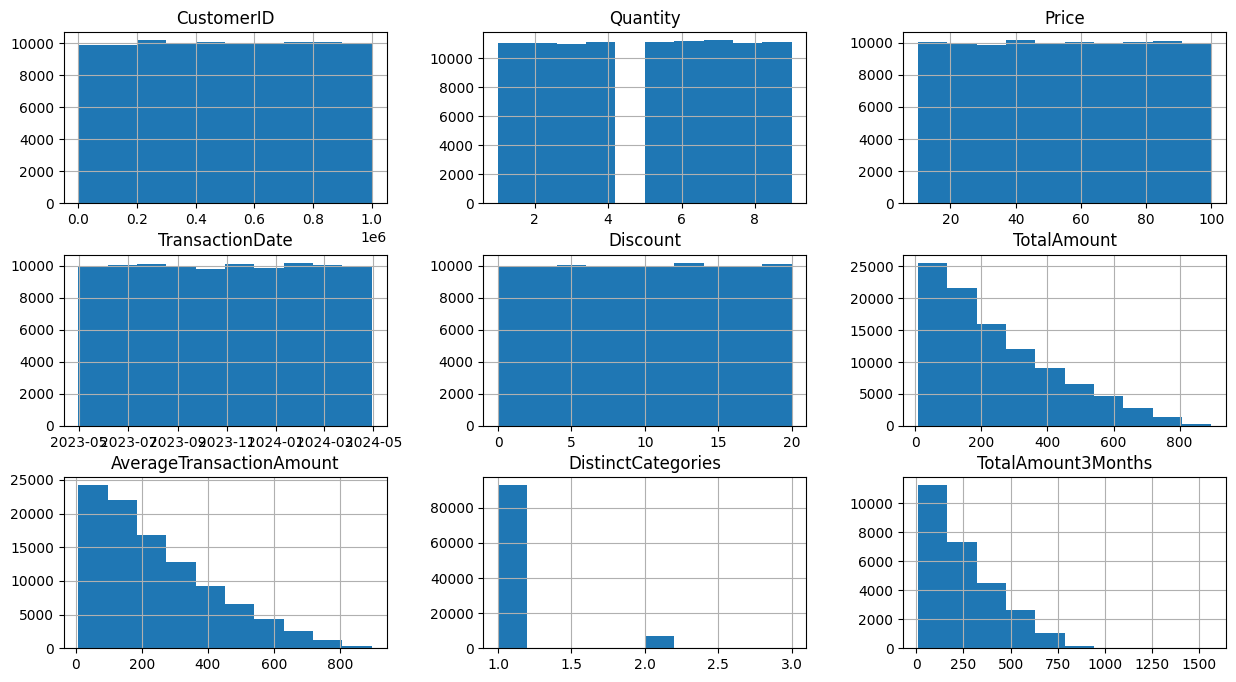

In [3340]:
df.hist(figsize=(15,8))

In [3341]:
# received at some point some error from the scaler, so I fixed it by filling the NaN's with 0

df['TotalAmount3Months'] = df['TotalAmount3Months'].fillna(0)

In [3342]:
# as part of the pre-processing, we remove duplicates in order to avoid bias/overfitting

df = df.drop_duplicates()

In [3343]:
# we will soon display a correlation map between our numerical values, so we separate them from other, of type string or object (np.bool integrates the IsHighValueNextMonth)

numeric_df = df.select_dtypes(include=[np.number, np.bool])

##### In order to find the relevant features that we will use to train the model, we display the correlation map between the numerical features, to see which are relevant and which are not

<Axes: >

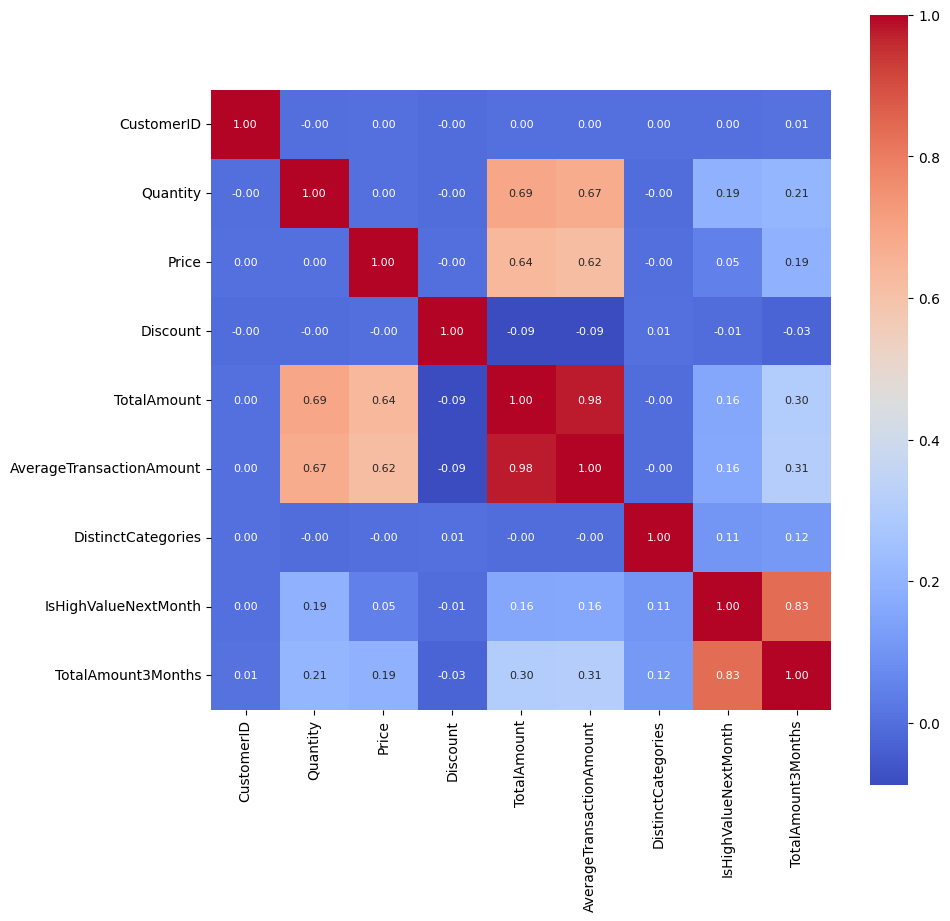

In [3344]:
_corr = numeric_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(_corr, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={"size": 8}, cmap="coolwarm")

##### From the correlation matrix above, I deduce that the most relevant feature is the 'TotalAmount3Months', followed by 'AverageTransactionAmount', 'Quantity', 'TotalAmount'

In [3345]:
# I tried some other rules to see how the correlation between the features changes, here are some notes on what I observed:
# - when the classes are more imbalanced (less isHighValueNextMonth true values/the rule is stricter), the 'TotalAmount3Months' feature is less relevant, while the other 3 are over 0.3 correlation
# - when having a rule that gives very few high value customers (very high class imbalance, again), the accuracy was high, but that was not a very good indicative (the model did not predict almost 
# none of the very few true values and yet got high accuracy, it pretty much winged it and assigned false to almost all)

features = ['AverageTransactionAmount','TotalAmount3Months', 'Quantity', 'TotalAmount']
X = df[features]
y = df['IsHighValueNextMonth']

In [3380]:
# played around with an imputer that assigns the mean of that column to missing values (one other option is to drop the row, but that implies losing values for other features)

imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

##### Using a scaler that standardizes features by removing the mean scaler.

In [3347]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

array([[<Axes: title={'center': 'CustomerID'}>,
        <Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'Price'}>],
       [<Axes: title={'center': 'TransactionDate'}>,
        <Axes: title={'center': 'Discount'}>,
        <Axes: title={'center': 'TotalAmount'}>],
       [<Axes: title={'center': 'AverageTransactionAmount'}>,
        <Axes: title={'center': 'DistinctCategories'}>,
        <Axes: title={'center': 'TotalAmount3Months'}>]], dtype=object)

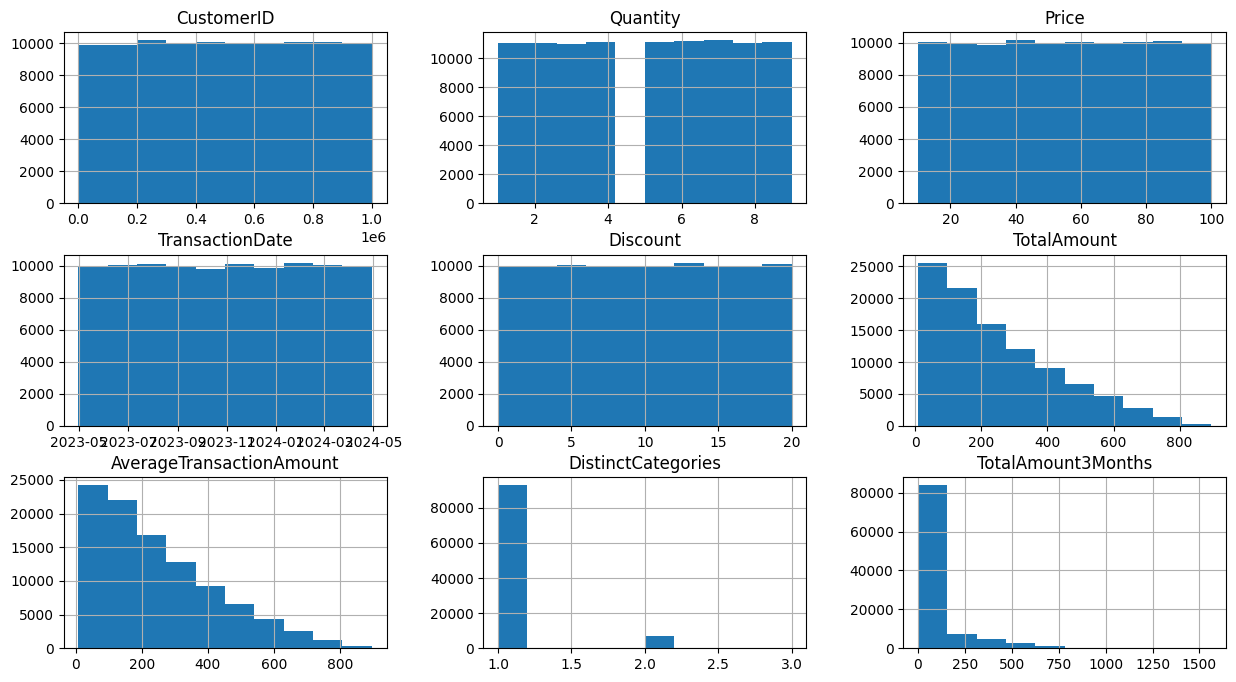

In [3348]:
df.hist(figsize=(15,8))

##### This is where we split the data into training and testing, reserving 70% of it for training and 30% for testing the accuracy

In [3349]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=2)

##### We use the LogisticRegression from skicit-lean, that we fit on our training data

In [3350]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

##### We compute the accuracy score, the confusion matrix and the classification report

In [3351]:
x_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print("Test Data Accuracy:", test_data_accuracy)

cm = confusion_matrix(y_test, x_test_prediction)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

print("\nClassification Report:")
print(classification_report(y_test, x_test_prediction))

Test Data Accuracy: 0.9815333333333334
Confusion Matrix:
[[23811   261]
 [  293  5635]]
True Negatives: 23811
False Positives: 261
False Negatives: 293
True Positives: 5635

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     24072
        True       0.96      0.95      0.95      5928

    accuracy                           0.98     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000



##### My dataset had high class imbalance (very few True values for isHighValueNextMonth) and because of that, my model had high accuracy. However, when looking at the confusion matrix, I realized that the False Negative predictions were very high with respect to my number of True values, meaning the model was classyfing pretty much everything as False and the accuracy score was pretty irelevant. This was the moment when I realized that my rule was too strong/strict/limiting.

##### Now, I train a second model, a RandomForestClassifier (obviously, suitable for a classification task like mine)

In [3352]:
model = RandomForestClassifier()

In [3353]:
model.fit(X_train, y_train)

RandomForestClassifier()

In [3354]:
x_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print("Test Data Accuracy:", test_data_accuracy)

cm = confusion_matrix(y_test, x_test_prediction)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

print("\nClassification Report:")
print(classification_report(y_test, x_test_prediction))

Test Data Accuracy: 0.9983
Confusion Matrix:
[[24048    24]
 [   27  5901]]
True Negatives: 24048
False Positives: 24
False Negatives: 27
True Positives: 5901

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     24072
        True       1.00      1.00      1.00      5928

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



##### The conclusion is that the RandomForestClassifier works better than the LogicalRegression model, since it has less false predictions.

##### Here, we look for some additional features that might be relevant

##### First, I realized that I neglected the string and object features right after I created the numerical dataframe for the correlation matrix. When looking upon them after, I decided to try and use the address - in the beginning, I tried using them raw, but realized they are unique, so I decied to extract the state from the address string (since states have different economical levels - people from well developded states might purchase more and be better potential high value customers)  

In [3355]:
def extract_state(address):
    parts = address.split(',')
    if len(parts) >= 2:
        state_zip = parts[-1].strip().split()
        if len(state_zip) >= 2:
            return state_zip[0]
    return None

df['State'] = df['StoreLocation'].apply(extract_state)

State
VI     0.223623
WV     0.216710
ID     0.215978
TX     0.213957
NE     0.213211
NH     0.212682
CT     0.210000
IN     0.209688
MN     0.207008
GA     0.206551
OH     0.206434
WI     0.202997
RI     0.202870
VA     0.201884
AR     0.201811
PA     0.201566
AK     0.200925
MO     0.200795
AZ     0.200658
Box    0.200435
CA     0.199725
IL     0.199607
MD     0.199601
OR     0.199115
NC     0.199059
VT     0.198675
OK     0.198381
MP     0.197903
PR     0.196970
DC     0.196919
NM     0.195795
AS     0.195458
MT     0.194921
MI     0.194678
NJ     0.193724
FM     0.193590
KS     0.193440
DE     0.192857
FL     0.192071
ND     0.191973
SD     0.191503
CO     0.191079
GU     0.190945
MS     0.190789
WA     0.188653
PW     0.188444
LA     0.188329
NV     0.187711
ME     0.187500
AL     0.187064
UT     0.185984
IA     0.185933
MA     0.185601
KY     0.185505
SC     0.185090
NY     0.184868
WY     0.184228
MH     0.183027
TN     0.176206
HI     0.168716
Name: IsHighValueNextMonth, dtype:

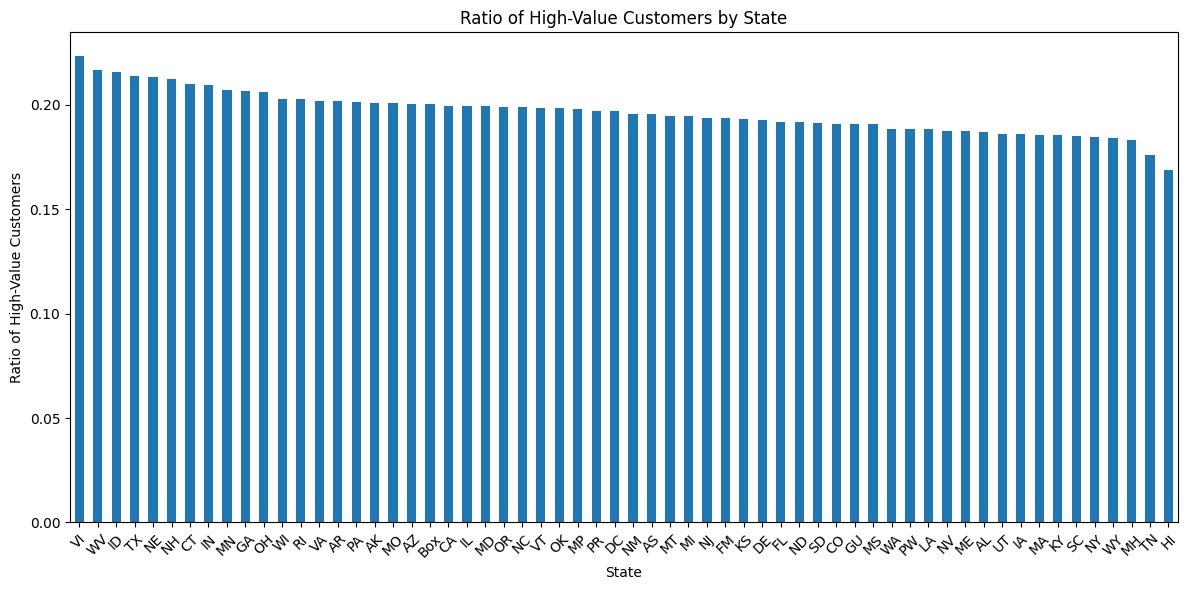

In [3356]:
state_hvc_ratio = df.groupby('State')['IsHighValueNextMonth'].mean().sort_values(ascending=False)
print(state_hvc_ratio)

plt.figure(figsize=(12, 6))
state_hvc_ratio.plot(kind='bar')
plt.title('Ratio of High-Value Customers by State')
plt.xlabel('State')
plt.ylabel('Ratio of High-Value Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Using the diagram above, I draw the conclusion that the state is not a relevant feature, since the high value customers are equally distributed over states.

##### This is when I got the idea to combine more than two either new or already existing features in order to create a new one. For the loyalty score, I take into consideration the purchase frequency (which consituted 40% of the loyalty score), the recency of the last purchase (which contributes to 30% of the new feature) and the consistency of purchases, using standard deviation (which makes up the final 30% of the score). While higher frequency directly correlates with higher loyalty, we must apply inverse transformations to the other two, because both a lower standard deviation and a more recent purchase correlate with higher loyalty.

In [3357]:
def calculate_loyalty_score(group):
    frequency = group['TransactionDate'].count() 
    
    last_purchase = group['TransactionDate'].max()
    recency = (df['TransactionDate'].max() - last_purchase).days
    
    purchase_intervals = group['TransactionDate'].diff().dt.days
    consistency = purchase_intervals.std()
    
    loyalty_score = (frequency * 0.4 + (365 - recency) / 365 * 0.3 + (1 / (consistency + 1)) * 0.3)
    
    return pd.Series({'LoyaltyScore': loyalty_score})

In [3358]:
# I include the loyalty score inside the main dataframe
# running this takes about 1 minute on my machine, but not more and seems to work fine

loyalty_scores = df.groupby('CustomerID').apply(calculate_loyalty_score).reset_index()
df = df.merge(loyalty_scores, on='CustomerID', how='left')

/tmp/ipykernel_5899/1514991038.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  loyalty_scores = df.groupby('CustomerID').apply(calculate_loyalty_score).reset_index()


In [3359]:
# we separate the numerical values, to create a correlation map again

numeric_df = df.select_dtypes(include=[np.number, np.bool_])

<Axes: >

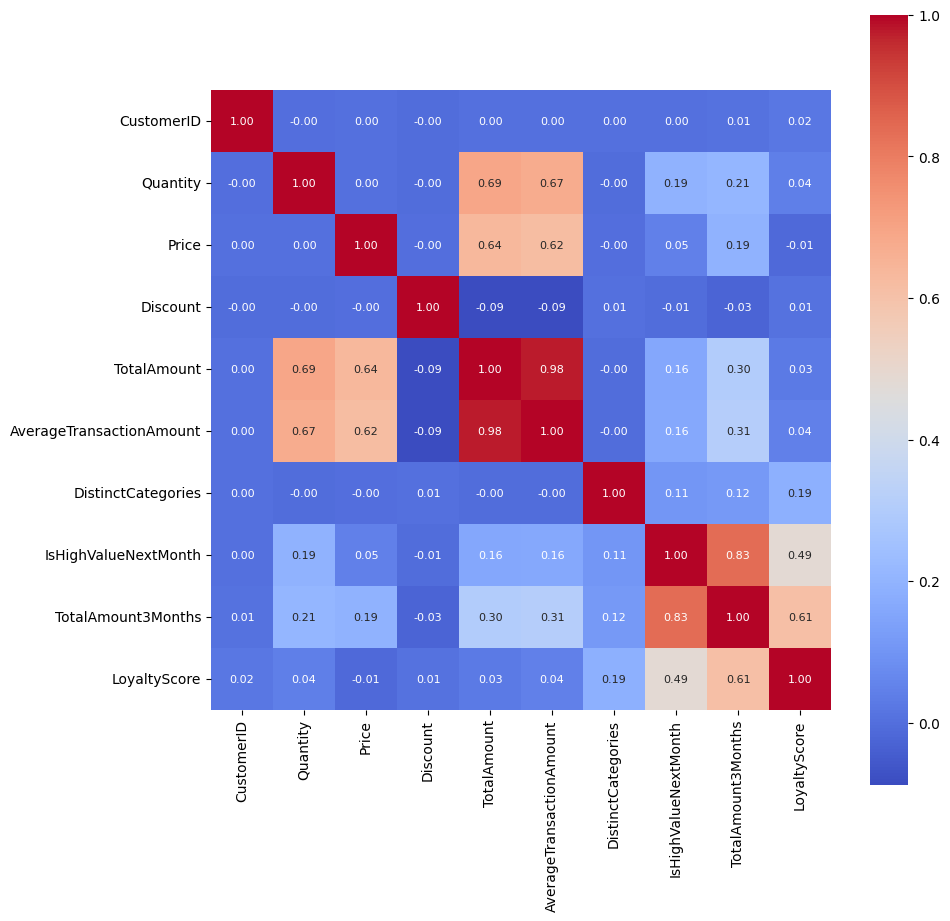

In [3360]:
_corr = numeric_df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(_corr, cbar=True, square=True, fmt='.2f', annot=True, annot_kws={"size": 8}, cmap="coolwarm")

##### From the new correlation map, I can draw the following conclusion: the loyalty score is definitely a relevant feature that i must include in training the model, together with the already discovered ones ('TotalAmount3Months', 'AverageTransactionAmount', 'Quality', 'TotalAmount' and 'DistinctCategories') 

In [3361]:
features = ['AverageTransactionAmount', 'TotalAmount3Months', 'Quantity', 'TotalAmount', 'LoyaltyScore', 'DistinctCategories']
X = df[features]
y = df['IsHighValueNextMonth']

In [3362]:
imputer = SimpleImputer(strategy='mean')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

In [3363]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X_imputed.columns)

In [3364]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.30, random_state=2)

In [3365]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [3366]:
x_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print("Test Data Accuracy:", test_data_accuracy)

cm = confusion_matrix(y_test, x_test_prediction)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

print("\nClassification Report:")
print(classification_report(y_test, x_test_prediction))

Test Data Accuracy: 0.9813666666666667
Confusion Matrix:
[[23811   261]
 [  298  5630]]
True Negatives: 23811
False Positives: 261
False Negatives: 298
True Positives: 5630

Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99     24072
        True       0.96      0.95      0.95      5928

    accuracy                           0.98     30000
   macro avg       0.97      0.97      0.97     30000
weighted avg       0.98      0.98      0.98     30000



In [3367]:
model = RandomForestClassifier(n_estimators=200, max_features='sqrt')
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [3368]:
x_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print("Test Data Accuracy:", test_data_accuracy)

cm = confusion_matrix(y_test, x_test_prediction)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

print("\nClassification Report:")
print(classification_report(y_test, x_test_prediction))

Test Data Accuracy: 0.9984333333333333
Confusion Matrix:
[[24045    27]
 [   20  5908]]
True Negatives: 24045
False Positives: 27
False Negatives: 20
True Positives: 5908

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     24072
        True       1.00      1.00      1.00      5928

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



##### The conclusion is that the RandomForestClassifier model is more suitable than the LogisticRegression model and the most relevant features are 'TotalAmount3Months' and 'LoyaltyScore'. I will, however, play some more with using only some of the features and see how they perform.

In [3369]:
features = ['TotalAmount3Months', 'LoyaltyScore']
X = df[features]
y = df['IsHighValueNextMonth']

In [3370]:
model = RandomForestClassifier(n_estimators=200, max_features='sqrt')
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [3371]:
x_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print("Test Data Accuracy:", test_data_accuracy)

cm = confusion_matrix(y_test, x_test_prediction)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

print("\nClassification Report:")
print(classification_report(y_test, x_test_prediction))

Test Data Accuracy: 0.9984666666666666
Confusion Matrix:
[[24046    26]
 [   20  5908]]
True Negatives: 24046
False Positives: 26
False Negatives: 20
True Positives: 5908

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     24072
        True       1.00      1.00      1.00      5928

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



The two most relevant features alone seem to give at least as good results as when features included less correlated features. Will try them independently. 

In [3372]:
features = ['TotalAmount3Months']
X = df[features]
y = df['IsHighValueNextMonth']

In [3373]:
model = RandomForestClassifier(n_estimators=200, max_features='sqrt')
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [3374]:
x_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print("Test Data Accuracy:", test_data_accuracy)

cm = confusion_matrix(y_test, x_test_prediction)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

print("\nClassification Report:")
print(classification_report(y_test, x_test_prediction))

Test Data Accuracy: 0.9984666666666666
Confusion Matrix:
[[24046    26]
 [   20  5908]]
True Negatives: 24046
False Positives: 26
False Negatives: 20
True Positives: 5908

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     24072
        True       1.00      1.00      1.00      5928

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



In [3375]:
features = ['LoyaltyScore']
X = df[features]
y = df['IsHighValueNextMonth']

In [3376]:
model = RandomForestClassifier(n_estimators=200, max_features='sqrt')
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200)

In [3377]:
x_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print("Test Data Accuracy:", test_data_accuracy)

cm = confusion_matrix(y_test, x_test_prediction)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

print("\nClassification Report:")
print(classification_report(y_test, x_test_prediction))

Test Data Accuracy: 0.9984333333333333
Confusion Matrix:
[[24044    28]
 [   19  5909]]
True Negatives: 24044
False Positives: 28
False Negatives: 19
True Positives: 5909

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     24072
        True       1.00      1.00      1.00      5928

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



##### The results above prove that both features are relevant enough to perform very well independently.

In [3378]:
# will conduct one last experiment

model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [3379]:
x_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(x_test_prediction, y_test)

print("Test Data Accuracy:", test_data_accuracy)

cm = confusion_matrix(y_test, x_test_prediction)
print("Confusion Matrix:")
print(cm)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

print("\nClassification Report:")
print(classification_report(y_test, x_test_prediction))

Test Data Accuracy: 0.9978333333333333
Confusion Matrix:
[[24039    33]
 [   32  5896]]
True Negatives: 24039
False Positives: 33
False Negatives: 32
True Positives: 5896

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     24072
        True       0.99      0.99      0.99      5928

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



##### The decision tree seems perform very well, just below the RandomForestsClassifier.

## Potential business use case

I believe that such predictive models applied to retail datasets can be used in order to identify high value customers, to which companies can, then, direct personalized offers. High value customers spend more money on products than usual customers and, therefore, bring more value to the company. Having a loyalty score implemented in the marketing framework that the company uses can contribute to developing special programs for valuable customers. Moreover, having insight into what each customer purchases (books, clothing, etc), the company can create personalized advertisement. Finally, such predictive models can help identity the reasons for which some customers do not purchase more products and fix these issues. 